In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from collections import Counter
from sklearn.datasets import make_classification
import seaborn as sns
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, precision_recall_curve,f1_score
from imblearn.metrics import geometric_mean_score
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense


#Fonctions de traitement

In [3]:
def data_balance_visualisation(df):
    counts_valus_class = df.Class.value_counts()
    plt.figure(figsize =(6,6))
    plt.pie(counts_valus_class, labels = ['Ligitime', 'Fraude'],
            colors =['green', 'red'],
            explode = [0, 0.2],
            autopct = lambda counts_valus_class: str(round(counts_valus_class,2)) +' %',
            pctdistance = 0.6, labeldistance = 1.2,
            shadow = True)
    plt.legend()
    plt.savefig('fraude_ligitime.png')

In [4]:
def ROC_courbe(y_pred, model):
  from sklearn import metrics
  fpr, tpr, thr = metrics.roc_curve(y_test, y_pred)
  auc = metrics.auc(fpr, tpr)
  fig = plt.figure(figsize=(6, 6))
  plt.plot(fpr, tpr, '-', lw=2,color='coral', label=' AUC=%.2f' % auc)

  plt.xlabel('1- specificite FPR', fontsize=14) #FPR
  plt.ylabel('Sensibilité TPR', fontsize=14) #TPR
  plt.title(' Courbe ROC - '+model, fontsize=14)
  plt.legend(loc="lower right", fontsize=10)
  plt.show()

In [5]:
def ROC_courbe_comparaison(y_pred_svm, y_pred_dtc, y_pred_ann):
  from sklearn import metrics
  fpr_svm, tpr_svm, thr_svm = metrics.roc_curve(y_test, y_pred_svm)
  fpr_dtc, tpr_dtc, thr_dtc = metrics.roc_curve(y_test, y_pred_dtc)
  fpr_ann, tpr_ann, thr_ann = metrics.roc_curve(y_test, y_pred_ann)

  auc_svm = metrics.auc(fpr_svm, tpr_svm)
  auc_dtc = metrics.auc(fpr_dtc, tpr_dtc)
  auc_ann = metrics.auc(fpr_ann, tpr_ann)

  fig = plt.figure(figsize=(15, 8))
  plt.plot(fpr_svm, tpr_svm, '-', lw=2, color='orange', label='Support vector machine: %.2f' % auc_svm)
  plt.plot(fpr_dtc, tpr_dtc, '-', lw=2, color='green', label='Decision tree: %.2f' % auc_dtc)
  plt.plot(fpr_ann, tpr_ann, '-', lw=2, color='red', label='Artificial neural network: %.2f' % auc_ann)

  plt.xlabel('1- specificite (False Positive Rate)', fontsize=14) #FPR
  plt.ylabel('Sensibilité (True Positive Rate)', fontsize=14) #TPR
  plt.title(' Courbe ROC - ', fontsize=14)
  plt.legend(loc="lower right", fontsize=10)
  plt.show()

In [6]:
def pca_visualisation(df):
    pca= PCA(n_components=2)
    data_fraude_pca= pd.DataFrame(pca.fit_transform(df.iloc[:,0:30]))
    data_fraude_pca= pd.concat([data_fraude_pca, df['Class']], axis=1)
    data_fraude_pca.columns= ['x', 'y', 'Class']
    sns.lmplot(x='x', y='y', data=data_fraude_pca, fit_reg=False, hue='Class', palette =['green', 'red'])

In [7]:
def correlation_matrix(df, number):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr, mask=mask, cmap="autumn", vmin = -1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax = ax)
    if(number==0):
        ax.set_title("Matrice de corrélation avec les données déséquilibrées")
    else: 
        ax.set_title("Matrice de corrélation avec les données équilibrées")

In [8]:
def matrics(cm):
  names = ['True Neg','False Pos','False Neg','True Pos']
  counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
  percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, fmt='', cmap='RdYlGn')

#Exploration des données

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
data_fraude_original = pd.read_csv('/content/drive/My Drive/memoire_m2/creditcard.csv')
#lire 5 premières lignes
data_fraude_original.insert(28, 'Time', data_fraude_original.pop('Time') ) 

In [11]:
#calculer le nombre transaction fraude/ non fraude
counts_valus_class = data_fraude_original.Class.value_counts()
print(counts_valus_class)

#calculer le ratio
ratio_cases = counts_valus_class/len(data_fraude_original.index)
print(ratio_cases)

0    284315
1       492
Name: Class, dtype: int64
0    0.998273
1    0.001727
Name: Class, dtype: float64


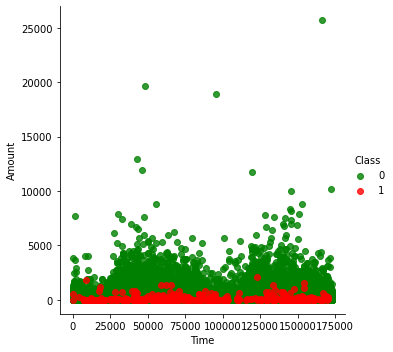

In [12]:
#afficher le nombre de transaction frauduleuse/ non frauduleuse en fonction du temps
sns.lmplot(x='Time', y='Amount', data=data_fraude_original, fit_reg=False, hue='Class', palette =['green', 'red'])

In [13]:
data_fraude_trans = data_fraude_original.copy()

Rob_scaler=RobustScaler()
data_fraude_trans['Std_Amount'] = Rob_scaler.fit_transform(data_fraude_trans['Amount'].values.reshape(-1, 1))
data_fraude_trans['Std_Time'] = Rob_scaler.fit_transform(data_fraude_trans['Time'].values.reshape(-1, 1))

data_fraude_trans = data_fraude_trans.drop(['Amount', 'Time'],axis=1)


0    284315
1       492
Name: Class, dtype: int64

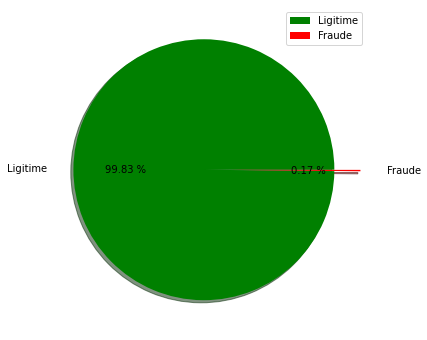

In [14]:
data_balance_visualisation(data_fraude_trans)
data_fraude_trans['Class'].value_counts()

#Matrice de corrélation avant l'échantillonnage

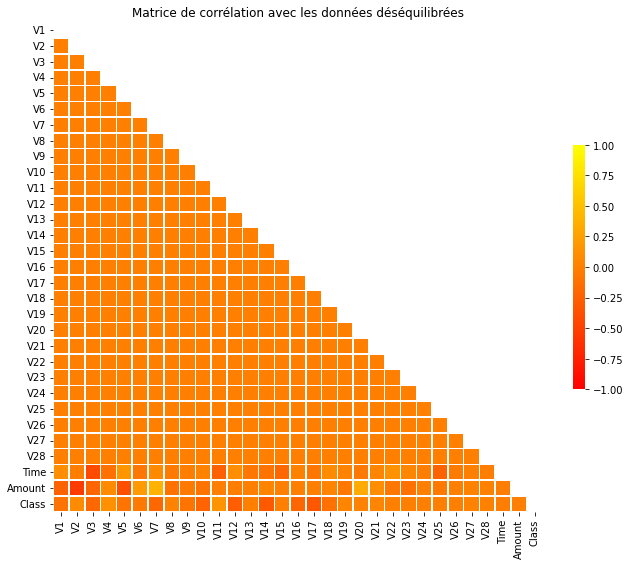

In [15]:
correlation_matrix(data_fraude_original,0)

#Analyse en composantes principales avant l'échantillonage

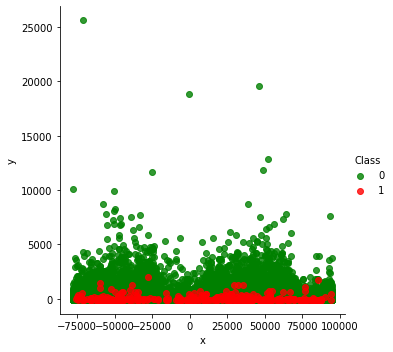

In [16]:
pca_visualisation(data_fraude_original)

En raison de problèmes de performances matérielles (PC), j'ai décidé de réduire mon dataFrame à 50 000 au lieu de 500 000 données ensuite les répartir avec un ratio de 50% des transaction fraudeleuses et de 50% non fraudeleuses

In [17]:
#réuire les données
df_class_0 = data_fraude_trans[data_fraude_trans['Class'] == 0].sample(50000)
df_class_1 = data_fraude_trans[data_fraude_trans['Class'] == 1]
new_datafame = pd.concat([df_class_0, df_class_1], axis=0)

In [18]:
new_datafame.shape

(50492, 31)

Afin de ne pas perdre nos données et de réduire notre dataFrame à 492 transactions, nous avons décidé d'appliquer le suréchantillonnage avec SMOTE, cela permettra de densifier plus équitablement les transactions frauduleuses.

In [19]:
X_original = new_datafame.drop('Class', axis=1)
Y_original = new_datafame['Class']
smote = SMOTE(sampling_strategy='minority')
X, Y = smote.fit_resample(X_original, Y_original)
Y.value_counts()

0    50000
1    50000
Name: Class, dtype: int64

#Répartition des données après l'échantillonage

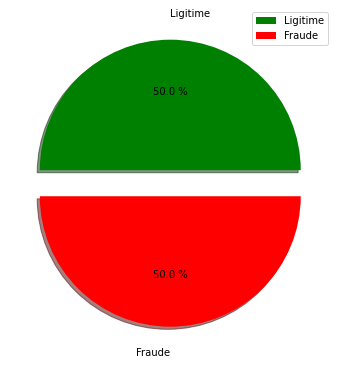

In [20]:
data_balance_visualisation(pd.concat([pd.DataFrame(X, columns=X.columns), pd.DataFrame(Y)]))

#Matrice de corrélation après l'échantillonage

In [21]:
correlation_matrix(pd.concat([pd.DataFrame(X, columns=X.columns), pd.DataFrame(Y)]),1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=15, stratify=Y)
y_train.value_counts()

0    40000
1    40000
Name: Class, dtype: int64

###Création de la matrice pour la comparaison

In [23]:
metrics = pd.DataFrame(index=[], columns=['SVM', 'ANN', 'DTC'])


#Application des modèles 

##Application des SVMs

In [24]:

model_svm = SVC(kernel='linear', probability=True)
model_svm.fit(X_train, y_train) 
y_pred_test_svm = model_svm.predict(X_test)

metrics.loc['accuracy', 'SVM'] = accuracy_score(y_pred=y_pred_test_svm, y_true=y_test)
metrics.loc['precision', 'SVM'] = precision_score(y_pred=y_pred_test_svm, y_true=y_test)
metrics.loc['recall', 'SVM'] = recall_score(y_pred=y_pred_test_svm, y_true=y_test)
metrics.loc['G-mean', 'SVM'] = geometric_mean_score(y_pred=y_pred_test_svm, y_true=y_test)
metrics.loc['f1_score', 'SVM'] = f1_score(y_pred=y_pred_test_svm, y_true=y_test)

cm_svm = confusion_matrix(y_pred=y_pred_test_svm, y_true=y_test)


###Matrice de confusion

In [25]:
matrics(cm_svm)


###Courbe ROC

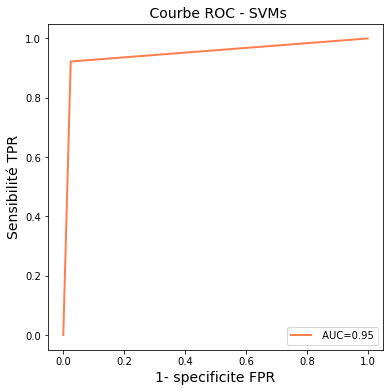

In [26]:
ROC_courbe(y_pred_test_svm, 'SVMs')

##Application des réseaux de neuronnes

In [27]:
model_ann = Sequential()
model_ann.add(Dense(activation = "relu", input_dim = 30, units = 6, kernel_initializer='uniform'))
model_ann.add(Dense(activation = "relu", units = 20, kernel_initializer='uniform'))
model_ann.add(Dense(activation = "relu", units = 10, kernel_initializer='uniform'))
model_ann.add(Dense(activation = "sigmoid", units = 1, kernel_initializer='uniform'))
model_ann.summary()
model_ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_ann.fit(X_train, y_train, epochs=100)
y_pred_test_ann = model_ann.predict(X_test)
y_pred_test_ann = np.round(y_pred_test_ann)

metrics.loc['accuracy', 'ANN'] = accuracy_score(y_pred=y_pred_test_ann, y_true=y_test)
metrics.loc['precision', 'ANN'] = precision_score(y_pred=y_pred_test_ann, y_true=y_test)
metrics.loc['recall', 'ANN'] = recall_score(y_pred=y_pred_test_ann, y_true=y_test)
metrics.loc['G-mean', 'ANN'] = geometric_mean_score(y_pred=y_pred_test_ann, y_true=y_test)
metrics.loc['f1_score', 'ANN'] = f1_score(y_pred=y_pred_test_ann, y_true=y_test)
print(classification_report(y_test, y_pred_test_ann))
cm_ann = confusion_matrix(y_pred=y_pred_test_ann, y_true=y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 186       
                                                                 
 dense_1 (Dense)             (None, 20)                140       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 547
Trainable params: 547
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1511 - accuracy: 0.9392
Epoch 2/100
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1025 - a

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


###Matrice de confusion

In [28]:
matrics(cm_ann)

###Courbe ROC

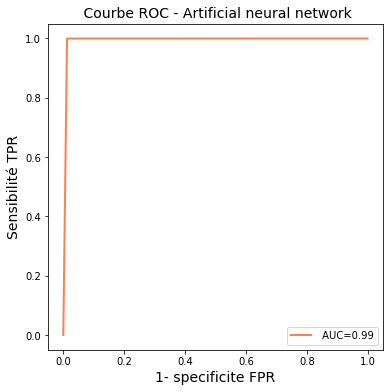

In [29]:
ROC_courbe(y_pred_test_ann, 'Artificial neural network')

##Application des arbres de décisions

In [30]:
model_dtc = DecisionTreeClassifier()
model_dtc.fit(X_train, y_train)
y_pred_test_dtc = model_dtc.predict(X_test)

metrics.loc['accuracy', 'DTC'] = accuracy_score(y_pred=y_pred_test_dtc, y_true=y_test)
metrics.loc['precision', 'DTC'] = precision_score(y_pred=y_pred_test_dtc, y_true=y_test)
metrics.loc['recall', 'DTC'] = recall_score(y_pred=y_pred_test_dtc, y_true=y_test)
metrics.loc['G-mean', 'DTC'] = geometric_mean_score(y_pred=y_pred_test_dtc, y_true=y_test)
metrics.loc['f1_score', 'DTC'] = f1_score(y_pred=y_pred_test_dtc, y_true=y_test)

cm_dtc = confusion_matrix(y_pred=y_pred_test_dtc, y_true=y_test)

###Matrice de confusion

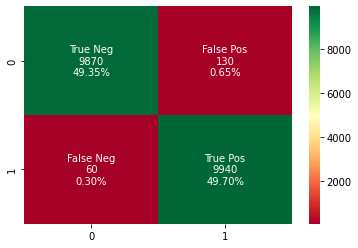

In [31]:
matrics(cm_dtc)

#Courbes ROC

In [32]:
ROC_courbe(y_pred_test_dtc, 'Tree Decision')

#Courbes ROC comparaison

In [33]:
ROC_courbe_comparaison(y_pred_test_svm, y_pred_test_dtc, y_pred_test_ann)

#Comparaison accuracy, precision, recall

In [34]:
metrics

SVM       ANN       DTC
accuracy    0.94895    0.9937    0.9905
precision  0.974226  0.987846   0.98709
recall       0.9223    0.9997     0.994
G-mean     0.948576  0.993682  0.990494
f1_score   0.947552  0.993738  0.990533